# Pokemon Classifier
Made with Fast AI

In [1]:
from fastai.vision.all import *
import nbdev
debug = False

In [2]:
path = Path('.').cwd()/'PokemonData'
path

Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData')

In [3]:
images = get_image_files(path)
images

(#6820) [Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/894adfbb050b4ae28914e18327fee4a4.jpg'),Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/4e3758843ef84f79be49d37d42291ed3.jpg'),Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/c79e64fe6b2647d6a34537536f7487bf.jpg'),Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/564a1c4959974f36b5a25610f7e81f42.jpg'),Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/8be42e059bda4a75bf549a2d08804cdc.jpg'),Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/16c3a65771044f689656e16e0c56f1c0.jpg'),Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/07ea12cb6f2d4236892737

In [4]:
failed = verify_images(images)

In [5]:
failed.map(Path.unlink)

(#0) []

In [6]:
doc(RandomResizedCrop)

In [7]:
pokemon = DataBlock(blocks = (ImageBlock,CategoryBlock),
                    get_items = get_image_files,
                    get_y = parent_label,
                    splitter = RandomSplitter(valid_pct = 0.2, seed = 1),
                    item_tfms = Resize(128, ResizeMethod.Pad, pad_mode = 'zeros'),
                    batch_tfms=aug_transforms(mult=1.5))

In [8]:
dls = pokemon.dataloaders(path)

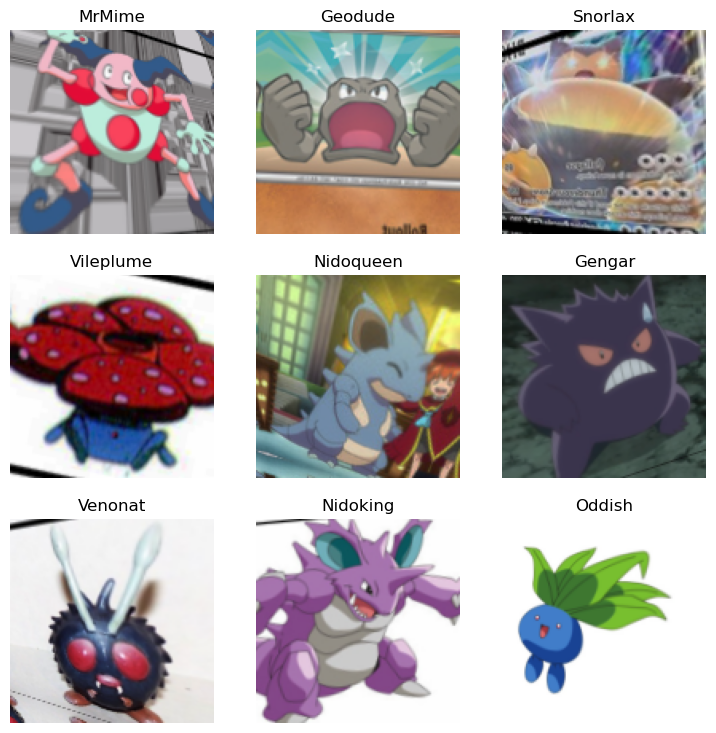

In [9]:
dls.train.show_batch()

## Using Resnet18

In [10]:
learner = vision_learner(dls, resnet18, metrics = error_rate)
learner.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,4.965808,2.462596,0.549853,00:15


epoch,train_loss,valid_loss,error_rate,time
0,2.706602,1.722390,0.396628,00:14
1,1.857506,1.052178,0.245601,00:14
2,1.181207,0.723197,0.186950,00:12
3,0.772371,0.583380,0.158358,00:12
4,0.508696,0.522521,0.153959,00:12
5,0.368503,0.497173,0.143695,00:11
6,0.271616,0.458830,0.130499,00:14
7,0.214224,0.436174,0.126100,00:13
8,0.175283,0.437245,0.123167,00:13
9,0.170324,0.434007,0.120968,00:12


After 10 iterations of fine tuning we can see that model has flatten its learning rate in the ending iterations.
## Let's try to find a good learning rate
And see if our performance improves by using it?

0.004365158267319202


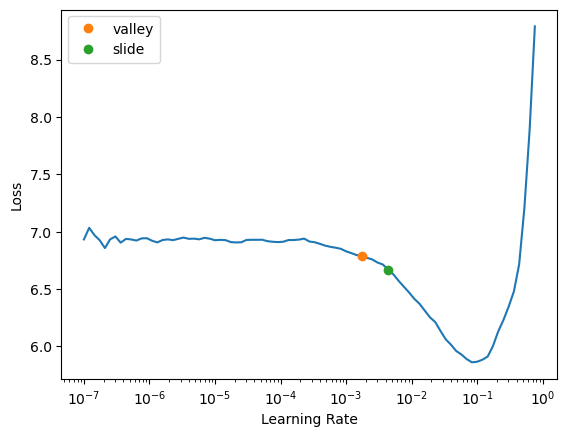

In [21]:
learner2 = vision_learner(dls, resnet18, metrics = error_rate)
l = learner2.lr_find(suggest_funcs=(valley, slide))
print(l.slide)

In [22]:
learner2.fine_tune(5, l.slide)

epoch,train_loss,valid_loss,error_rate,time
0,4.250410,1.898616,0.461877,00:12


epoch,train_loss,valid_loss,error_rate,time
0,1.623809,0.941292,0.252933,00:11
1,1.028341,0.682375,0.192082,00:12
2,0.636857,0.542718,0.147361,00:11
3,0.349029,0.454847,0.113636,00:12
4,0.229091,0.428394,0.108504,00:12


In [13]:
doc(plt)

In [14]:
# Using recorder to get values
if debug:
    train_loss = [item[0] for item in learner.recorder.values]
    valid_loss = [item[1] for item in learner.recorder.values]
    error_rate = [1 - item[2] for item in learner.recorder.values]
    print(train_loss, valid_loss, error_rate, sep = '\n')

We got similar accurate model when we used a good learning rate in nearly half iterations.
## Checking prediction

In [16]:
TestInput = Path('.').cwd()/'TestInputs'
categories = learner.dls.vocab

In [17]:
def predict(img):
    pred, idx, probs = learner2.predict(img)
    idx = dict(zip(categories, map(float, probs)))
    return pred, idx[pred]

In [39]:
img = TestInput/'01.jpg'
predict(img)

('Hypno', 0.49585404992103577)

In [19]:
learner2.export(fname = 'resnet18_glr_pokemon.pkl')

## Resnet34
Trying out the resnet 34 model to see the comparision

In [24]:
# Resnet34
learner34_1 = vision_learner(dls, resnet34, metrics = error_rate)
learner34_1.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,5.016372,2.357561,0.532258,00:12


epoch,train_loss,valid_loss,error_rate,time
0,2.500234,1.458496,0.337977,00:14
1,1.614385,0.829477,0.206012,00:14
2,0.948798,0.603201,0.158358,00:14
3,0.570228,0.513255,0.134897,00:14
4,0.384945,0.458124,0.120235,00:14
5,0.266048,0.419388,0.108504,00:14
6,0.188456,0.404413,0.099707,00:14
7,0.128991,0.383431,0.100440,00:14
8,0.103187,0.378058,0.097507,00:15
9,0.089589,0.377691,0.096774,00:15


### Resnet34 with good learning rate

0.004365158267319202

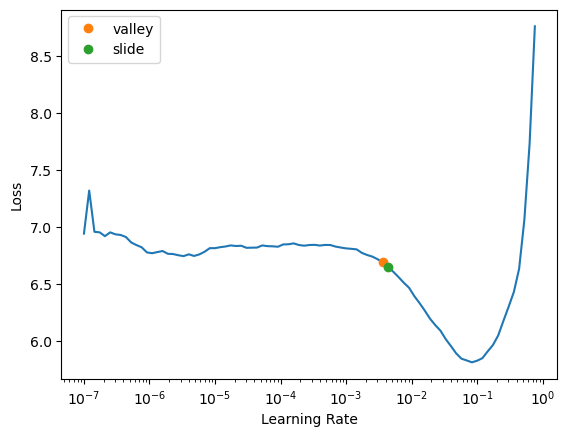

In [29]:
# Resnet34 with good learning rate
learner34_2 = vision_learner(dls, resnet34, metrics = error_rate)
lr = learner34_2.lr_find(suggest_funcs=(valley, slide))
lr.slide

In [30]:
learner34_2.fine_tune(5, lr.slide)

epoch,train_loss,valid_loss,error_rate,time
0,4.203328,1.747029,0.425953,00:13


epoch,train_loss,valid_loss,error_rate,time
0,1.477972,0.741926,0.200147,00:15
1,0.907752,0.672446,0.175953,00:15
2,0.541178,0.501797,0.134164,00:15
3,0.282189,0.381754,0.107771,00:17
4,0.171106,0.369103,0.104106,00:16


In [38]:
def predict34(img):
    pred, idx, probs = learner34_2.predict(img)
    idx = dict(zip(categories, map(float, probs)))
    return pred, idx[pred]
    
img = TestInput/'04.png'
predict34(img)

('Clefairy', 0.5982404947280884)

In [40]:
learner34_2.export(fname = 'resnet34_glr_pokemon.pkl')

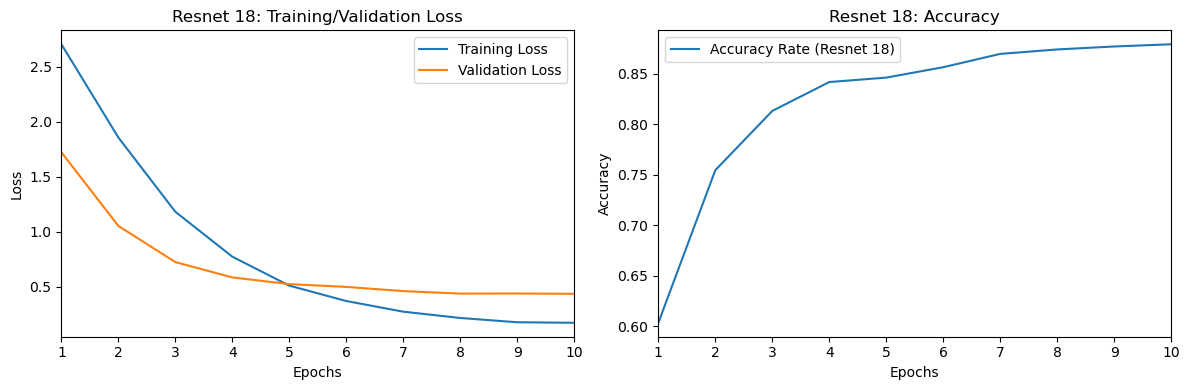

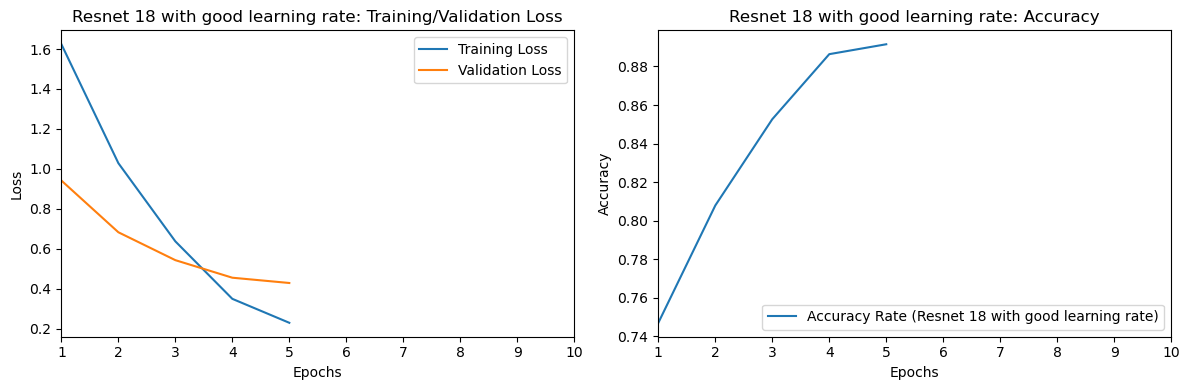

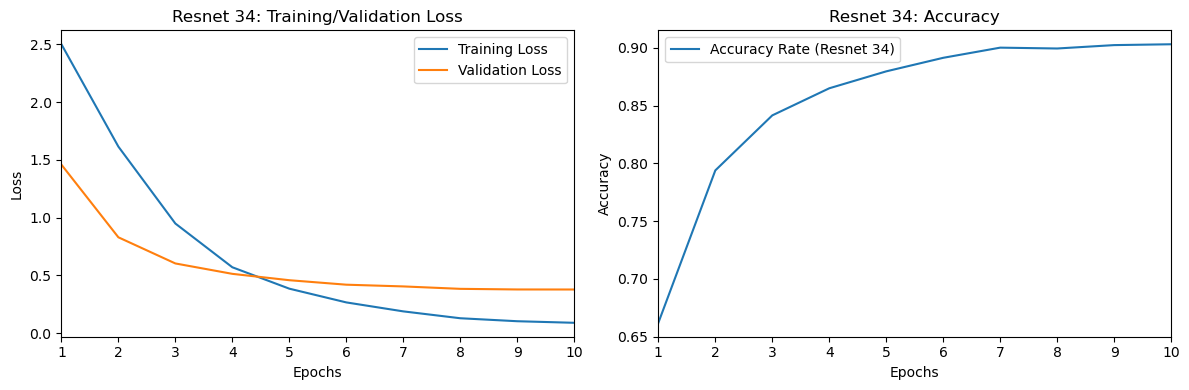

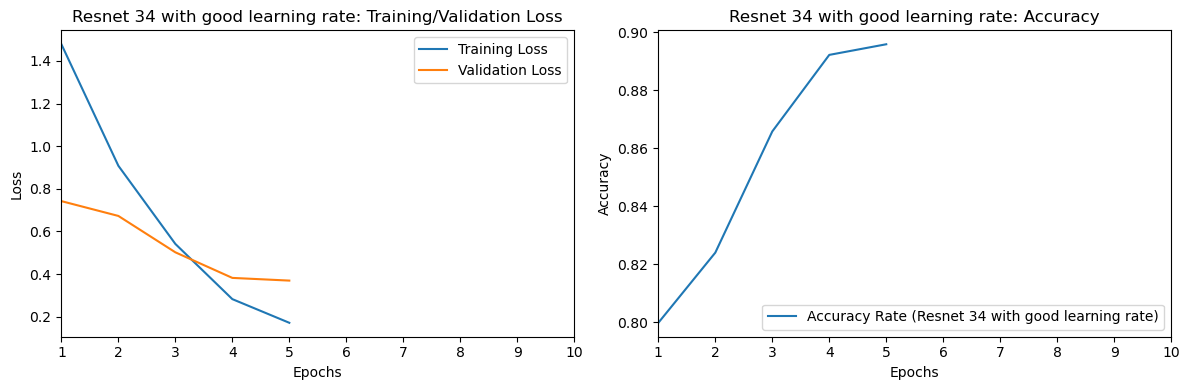

In [37]:
# Plotting training history for both learners
def plot_training_history(learn, label):
    # Extract training loss, validation loss, and error rate from training history
    train_loss = [item[0] for item in learn.recorder.values]
    valid_loss = [item[1] for item in learn.recorder.values]
    error_rate = [1 - item[2] for item in learn.recorder.values]

    # Plotting
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12, 4))

    # Plotting training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label=f'Training Loss')
    plt.plot(epochs, valid_loss, label=f'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(label + ': Training/Validation Loss')
    plt.xlim(1, 10)
    plt.legend()

    # Plotting error rate
    plt.subplot(1, 2, 2)
    plt.plot(epochs, error_rate[:10], label=f'Accuracy Rate ({label})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(label + ': Accuracy')
    plt.xlim(1, 10)
    plt.legend()

    plt.tight_layout()
    plt.show()

# if debug:
# Plotting training history for learner1
plot_training_history(learner, 'Resnet 18')

# Plotting training history for learner2
plot_training_history(learner2, 'Resnet 18 with good learning rate')

# Plotting training history for learner1
plot_training_history(learner34_1, 'Resnet 34')

# Plotting training history for learner2
plot_training_history(learner34_2, 'Resnet 34 with good learning rate')




# Outcomes
- We see that difference in training model with good learning rate makes training model more efficient as it nearly requires half of the epoch with default learning rate.
- We also find that model starts to overfit as only the error rate decreases for the training set after epoch 5 for Resnet18/34. It shows that model is not learning anymore and has started to overfit.
### Why learning rate is so important? 
If we find good LR it would optimize our training process and can help us when we need to train large models as the effect at that time would be compunded.
### Choosing model?
Resnet18 vs Resnet34: Both model gave us similar result in terms of accuracy and training time (Resnet34 taking slight longer).
If we should take into account the optimization for storage we can go with resnet18 and if we prefer more accurate model resnet34 seems a better choice.

## Part 2 
Attempt to improving performance of model with Resnet50. There are about 150 different categories of pokemon that is required for classification.

In [41]:
len(learner.dls.vocab)

150

In [11]:
learner50 = vision_learner(dls, resnet50, metrics = error_rate)
learner50.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,4.475375,2.123032,0.479472,00:34


epoch,train_loss,valid_loss,error_rate,time
0,1.957847,1.396753,0.322581,00:34
1,1.271785,0.825954,0.196481,00:33
2,0.750118,0.575570,0.154692,00:33
3,0.444449,0.472257,0.130499,00:33
4,0.294329,0.404814,0.112170,00:33
5,0.200047,0.392939,0.107038,00:33
6,0.139075,0.342680,0.094575,00:33
7,0.112330,0.333564,0.090176,00:33
8,0.084067,0.327685,0.083578,00:34
9,0.070167,0.327993,0.086510,00:33


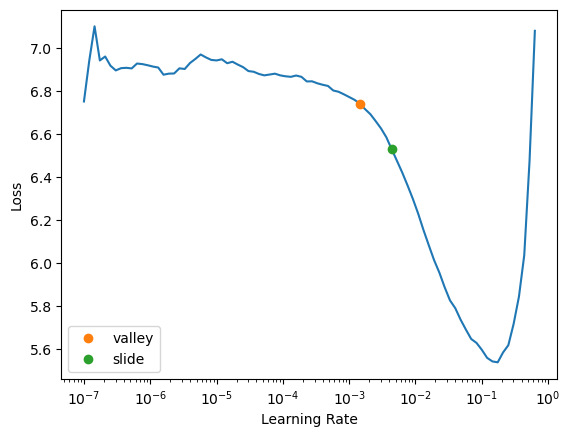

In [12]:
learner50_2 = vision_learner(dls, resnet50, metrics = error_rate)
lr50 = learner50_2.lr_find(suggest_funcs=(valley, slide))

In [13]:
learner50_2.fine_tune(5, lr50.slide)

epoch,train_loss,valid_loss,error_rate,time
0,3.766255,1.751113,0.424487,01:21


epoch,train_loss,valid_loss,error_rate,time
0,1.237564,0.743764,0.201613,01:38
1,0.694966,0.529260,0.136364,01:43
2,0.366119,0.387682,0.102639,01:39
3,0.196794,0.348623,0.092375,01:44
4,0.127216,0.334923,0.093109,01:46
